# Query CVE information

## Introduction

- UUID: **efda7766-78f6-4444-8072-beac92eaae97**
- Started from [issue 25](https://github.com/MISP/misp-playbooks/issues/25)
- State: **Published** : demo version with **output**
- Purpose:
    - This playbook queries the MISP events for the use of specific CVEs. It lists the events with the context (galaxies) that are attached to the event. 
    - The playbook queries public sources (CVE search, vulners, XForceExchange, exploitdb) for additional CVE information. 
    - The results are stored in the playbook, in a MISP event and sent to Mattermost and TheHive.
- Tags: [ "cve", "vulnerability", "exploits" ]    
- External resources: **cvesearch**, **vulners**, **XForceExchange**, **exploitdb**, **Mattermost, TheHive**
- Target audience: **SOC, CSIRT, CTI**
- Graphical workflow

![helpers/playbook-query_cve_information.png](helpers/playbook-query_cve_information.png)

# Playbook TOC

- **Query CVE information**
   - Introduction
- **Preparation**
   - PR:1 Initialise environment
   - PR:2 Verify MISP modules
   - PR:3 Load helper functions
   - PR:4 Set helper variables
   - PR:5 User input: CVE to investigate?
   - PR:6 MISP event details
   - PR:7 Create MISP event
- **Investigate**
   - IN:1 Attribute details
   - IN:2 Add the CVE to the event
   - IN:3 Query CVE advanced module
   - IN:4 Query vulners module
   - IN:5 Query IBM XForceExchange module
   - IN:6 Query ExploitDB
   - IN:7 Other queries
- **Correlation**
   - CR:1 Correlation with MISP events
   - CR:2 Correlation with MISP feeds
- **Closure**
   - EN:1 Create the summary of the CVE information
   - EN:2 Create the summary of the playbook
   - EN:3 Send a summary to Mattermost
   - EN:4 Send an alert to TheHive
   - EN:5 Publish MISP event
   - EN:6 End of the playbook
   - External references
   - Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Indicate if PyMISP should attempt to verify the certificate or ignore errors

mattermost_playbook_user
mattermost_hook
thehive_url
thehive_key
vulners_apikey
xforce_apikey
xforce_apipassword
```

In [1]:
# Initialise Python environment
import urllib3
import sys
import json
from prettytable import PrettyTable, MARKDOWN
from datetime import date
import requests
import uuid
from pymisp import *
import time
import csv
import codecs
from contextlib import closing
from IPython.display import display, Image, Markdown, display_markdown

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

/tmp/ipykernel_618068/3451753110.py:9: DeprecationWarning: 
As our baseline system is the latest Ubuntu LTS, and Ubuntu LTS 22.04 has Python 3.10 available,
we will officially deprecate python versions below 3.10 on January 1st 2024.
**Please update your codebase.**
  from pymisp import *
The version of PyMISP recommended by the MISP instance (2.4.172) is newer than the one you're using now (2.4.168.1). Please upgrade PyMISP.


The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Verify MISP modules

This playbook uses the MISP modules for correlation or enrichment. [MISP modules](https://github.com/MISP/misp-modules) are autonomous modules that can be used to extend MISP for new services such as expansion, import and export. The modules are written in Python 3. We first check if we have access to the **MISP module** server and if we find the modules. 

Note that for this playbook these modules do not need to be enabled in MISP. The playbook can use the MISP modules, even if they are not enabled for MISP.

In [2]:
# Modules used in this playbook
misp_modules_in_use = ["cve_advanced", "vulners", "xforceexchange"]

# Where can we find the local MISP Module server? You can leave this to the default setting in most cases.
misp_modules_url = "http://127.0.0.1:6666"

# How long do we wait between queries when using the MISP modules (API rate limiting of external service such as VirusTotal)
misp_modules_wait = 3

# Initiliasation
misp_modules = {}
misp_modules_headers = {
    "Content-Type": "application/json",
    "Accept": "application/json"
}

# Query the MISP module server and check if our modules are available
res = requests.get("{}/modules".format(misp_modules_url), headers=misp_modules_headers)
for module in res.json():
    for module_requested in misp_modules_in_use:
        if module.get("name", False) == module_requested:
            misp_modules[module_requested] = {"enabled": True, "input": module.get("mispattributes").get("input")}
            print("Found the \033[92m{}\033[90m MISP module\n Accepted input: {}.".format(module_requested, misp_modules[module_requested]["input"]))
print("\n\n")

Found the cve_advanced MISP module
 Accepted input: ['vulnerability'].
Found the xforceexchange MISP module
 Accepted input: ['ip-src', 'ip-dst', 'vulnerability', 'md5', 'sha1', 'sha256', 'domain', 'hostname', 'url'].
Found the vulners MISP module
 Accepted input: ['vulnerability'].





## PR:3 Load helper functions

The next cell contains **helper functions**. Instead of distributing helper functions as separate Python files this playbook includes the required code as one code cell. This makes portability of playbooks easier. The downside is that functions need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration it is chosen to include the code in the playbook (more portability), but you can easily create a "helper" file with the code and import that file in each playbook.

In [3]:
def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
    misp_tags = []
    for el in tags:
        t = MISPTag()
        t.name = el
        t.local = False
        misp_tags.append(t)

    for el in local_tags:
        t = MISPTag()
        t.name = el
        t.local = True
        misp_tags.append(t)
    return misp_tags


def pb_add_enrichment(playbook_results, field, entry, key, value):
    '''
    Add an enrichment (or correlation) entry but first check that the value is not already there

    : param playbook_results: all the enrichment results
    : param field
    : param entry
    : param key
    : param value
    '''
    skip_field = False
    for existing_entry in playbook_results.get(field, []):
        if existing_entry.get(key, False) == value:
            skip_field = True
            print(" Not adding to playbook results because of duplicate. Already added via {}".format(existing_entry.get("source", False)))
    if not skip_field:
        if field in playbook_results:
            playbook_results[field].append(entry)
        else:
            playbook_results[field] = [entry]
    return playbook_results


def pb_analyse_tags(tags, tags_to_analyse, tags_to_skip):
    '''
    Analyse a list of MISP tags. Remove unwanted tags and put other tags (fe. MITRE) in buckets

    : param tags
    : param tags_to_analyse
    : param tags_to_skip
    '''
    tags_to_return = []
    tags_analysed = {}
    
    for tag in event.tags:
        skip_tag = False
        for skip in tags_to_skip:
            if skip in tag.name:
                skip_tag = True
        if not skip_tag:
            tags_to_return.append(tag.name)
            for el in tags_to_analyse:
                if tags_to_analyse[el] in tag.name.strip():
                    match = tag.name.strip().split(tags_to_analyse[el])[1].replace("\"", "").strip()
                    if len(tags_analysed.get(el, [])) > 0:
                        tags_analysed[el].append(match)
                    else:
                        tags_analysed[el] = [match]
    return tags_to_return, tags_analysed


print("\033[92mHelper functions loaded\033[90m.\n\n".format(misp_url))

Helper functions loaded.




## PR:4 Set helper variables

This cell contains **helper variables** for this playbook.

In [4]:
# Dictionary to playbook results and some of the core objects that are created
playbook_results = {}
case_objects = {}

# Init variables
table_mispevents = ""
table_mispevents_tools_malware_malpedia = ""
table_mispevents_sector_country = ""
table_exploitdb = ""
summary = ""
summary_cve = {}

## PR:5 User input: CVE to investigate?

This cell is the primary <strong><font color=red>user input</font></strong> for this playbook.
Define the list of **CVE** to investigate with this playbook. 

The variable `query` can contain one CVE or a list of CVE.

In [5]:
# Provide one or more CVE
query = ["CVE-2021-44228", "CVE-2022-41082"]

# Simple function to always make a list, even if there is only one value. Makes it more consistent to work with the user input in the next cells.
if type(query) == str:
    query =[query]
print("The playbook will do the query for \033[92m{}\033[90m\n".format(query))

The playbook will do the query for ['CVE-2021-44228', 'CVE-2022-41082']



## PR:6 MISP event details

### Event title

In this playbook we create a **new** MISP event with title **CVE investigation for CVE-XXXX** (defined in `event_title`). Tt is good practice to choose a self-explanatory **event title**. This title is shown in the event index and should provide the necessary information to understand what the event is about. Avoid using generic event titles such as "phishing incident" or "infection". Read [Best Practices in Threat Intelligence](https://www.misp-project.org/best-practices-in-threat-intelligence.html) for further guidance.

### Contexualisation

This playbook adds contexualisation via **tags** defined in `event_additional_global_tags` and `event_additional_local_tags`. Whereas *global* tags remain attached to the events that you share with your community, the *local* tags are not shared outside your organisation. It's also a good idea to only use tags part of a [taxonomy](https://github.com/MISP/misp-taxonomies), this allows you to make the contexualisation portable across multiple MISP instances.

### Traffic Light Protocol

The default **TLP** for this event is **<span style='color:#FFBF00'>tlp:amber</span>**. The Traffic Light Protocol (TLP) facilitates sharing of potentially sensitive information and allows for more effective collaboration. TLP is a set of four standard labels to indicate the sharing boundaries to be applied by the recipients. TLP is set by the creator of information. You can find more information at [FIRST](https://www.first.org/tlp/). You can specify the TLP via `event_tlp`.

### MISP Galaxies

This playbook adds MISP galaxies with the variable `event_galaxies`. In this playbook we add relevant techniques from MITRE and classifications from [ENISA](https://www.enisa.europa.eu/publications/reference-incident-classification-taxonomy).

### MISP distribution, threat level and analysis level

You can specifiy a MISP **distribution** (with `event_distribution`), **threat level** (with `event_threat_level_id`) or **analysis state** (with `event_analysis`). The event **date** is set to today via `event_date`. If you cannot remember the options for distribution, threat level or the analysis state then use the next cell to guide you. This cell is set as **raw**. If you **change its type to code** and execute the cell you get an overview of the options available for creating a MISP event.

### Summary

- `event_title`: event title
- `event_tlp`: event TLP
- `event_additional_global_tags`: event global tags
- `event_additional_local_tags`: eventlocal tags
- `event_galaxies`: galaxies
- `event_distribution`: distribution
- `event_threat_level_id`: threat level
- `event_analysis`: analysis
- `event_date`: date

In [6]:
# Provide the event title for a new event. Leave blank for the playbook to auto generate one
event_title = ""

# Prefix for auto generate event title
event_title_default_prefix = "CVE investigation"

# Optionally, you can change TLP, add additional event (local and global) tags, threatlevel, analysis state or distribution level
event_tlp = "tlp:amber"

# Event context
event_additional_global_tags = []                                 # This needs to be a Python list
event_additional_local_tags = ["workflow:state=\"incomplete\""]   # This needs to be a Python list

# Event galaxies
event_galaxies = ["misp-galaxy:rsit=\"Vulnerable:Vulnerable system\"",
                  "misp-galaxy:mitre-attack-pattern=\"Active Scanning - T1595\"",
                  "misp-galaxy:mitre-attack-pattern=\"Vulnerability Scanning - T1595.002\"",
                  "misp-galaxy:mitre-attack-pattern=\"Vulnerabilities - T1588.006\""]

# Additional MISP event settings
event_threat_level_id = ThreatLevel.low
event_analysis = Analysis.ongoing
event_distribution = Distribution.your_organisation_only
event_date = date.today()

## PR:7 Create MISP event

The next cell **creates the MISP event** and stores the reference to the event in the variable `misp_event`.

In [7]:
# Code block to create the event or add data to an existing event
event_title = event_title.strip()

if not(event_title is str and len(event_title) > 0):
    event_title = "{} for {}".format(event_title_default_prefix, ' '.join(query))

# Construct the event tags
event_additional_global_tags.append(event_tlp)
event_additional_global_tags.append(event_galaxies)
event_tags = pb_get_misp_tags(event_additional_global_tags, event_additional_local_tags)

# Create the PyMISP object for an event
event = MISPEvent()
event.info = event_title
event.distribution = event_distribution
event.threat_level_id = event_threat_level_id
event.analysis = event_analysis
event.set_date(event_date)

# Create the MISP event on the server side
misp_event = misp.add_event(event, pythonify=True)
print("Continue the playbook with the new MISP event ID \033[92m{}\033[90m with title \033[92m{}\033[90m and UUID \033[92m{}\033[90m ".format(misp_event.id, misp_event.info, misp_event.uuid))
for tag in event_tags:
    misp.tag(misp_event.uuid, tag, local=tag.local)
    print(" \033[92mAdded\033[90m event tag {}".format(tag))
print("\n\n")

Continue the playbook with the new MISP event ID 3047 with title CVE investigation for CVE-2021-44228 CVE-2022-41082 and UUID aca12dc5-58b8-44fe-92e7-0433b3c762e4 
 Added event tag <MISPTag(name=tlp:amber)>
 Added event tag <MISPTag(name=['misp-galaxy:rsit="Vulnerable:Vulnerable system"', 'misp-galaxy:mitre-attack-pattern="Active Scanning - T1595"', 'misp-galaxy:mitre-attack-pattern="Vulnerability Scanning - T1595.002"', 'misp-galaxy:mitre-attack-pattern="Vulnerabilities - T1588.006"'])>
 Added event tag <MISPTag(name=workflow:state="incomplete")>





# Investigate

This section of the playbook does the heavy lifting. It adds the CVE that are investigated and queries external sources for additional information.

## IN:1 Attribute details

You can set context details (tags) for the attributes via `attribute_tags`. With `attribute_type_to_tag` you specify which attribute type needs to be tagged.

You can also specify with `attribute_to_skip` which attributes should not be imported. For example for vulnerabilities the list of external links or CPE references can substantially  blow up your threat event.

In [8]:
# Which tags to add to attributes
attribute_tags = pb_get_misp_tags(["PAP:WHITE", "kill-chain:Exploitation", "cycat:type=\"vulnerability\""])

# Which attribute to tag with attribute_tags
attribute_type_to_tag = ["vulnerability", "weakness"]

# Skip attributes of this type when received from external sources
attribute_to_skip = ["link", "cpe"]
#attribute_to_skip = []

## IN:2 Add the CVE to the event

The next cell will add the CVE to investigate as individual MISP objects.

## IN:3 Query CVE advanced module

The MISP module [cve_advanced](https://cve.circl.lu/) is used to gather vulnerability, weaknesses and attack-pattern information. The objects are added to MISP, together with their references.

In [9]:
module_name = "cve_advanced"
module_source = module_name
module_comment = "From {}".format(module_source)
module_run = 0

cve_to_add_manually = []

if misp_modules[module_name]["enabled"] and len(query) > 0:
    for value in query:
        # Wait 'misp_modules_wait' before doing the next query (take into account rate limiting)
        if module_run == 0:
            module_run = 1
        else:
            module_run += 1
            time.sleep(misp_modules_wait)
        attribute_type = "vulnerability"
        data = {
            "attribute": {
                "type": f"{attribute_type}",
                "uuid": str(uuid.uuid4()),
                "value": f"{value}",
            },
            "module": module_name,
            "config": {}
        }
        print("Query \033[92m{}\033[90m".format(value))
        result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
        if "results" in result.json() and len(result.json()["results"]) > 0:
            result_json = result.json()["results"]
            for misp_attribute in result_json.get("Attribute", []):
                if misp_attribute["type"] in attribute_to_skip:
                    print(" Skip {} \033[96m{}\033[90m".format(misp_attribute["type"], misp_attribute["value"]))
                    continue
                else:
                    misp_attribute["comment"] = "{}{}".format(module_comment, misp_attribute.get("comment", ""))
                    try:
                        created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
                        if misp_attribute["type"] in attribute_type_to_tag:
                            for tag in attribute_tags:
                                misp.tag(created_attribute, tag)
                    except:
                        print(" Unable to add {} \033[92m{}\033[90m to MISP event".format(misp_attribute["type"], misp_attribute["value"]))
            misp_object_references = []
            misp_attribute_in_object_to_tag = []
            for misp_object in result_json.get("Object", []):
                if misp_object["name"] in attribute_to_skip:
                    print(" Skip {}".format(misp_object["name"]))
                    continue
                else:
                    misp_object["comment"] = "{}{}".format(module_comment, misp_object.get("comment", ""))
                    new_attribute_list = []
                    entry = {}
                    for attribute in misp_object.get("Attribute", []):
                        if attribute["type"] in attribute_to_skip:
                            True
                        else:
                            entry[attribute["object_relation"]] = attribute["value"]
                            attribute["comment"] = module_comment
                            if attribute["type"] in attribute_type_to_tag:
                                misp_attribute_in_object_to_tag.append(attribute["uuid"])
                            new_attribute_list.append(attribute)
                    misp_object["Attribute"] = new_attribute_list
                    if len(misp_object["Attribute"]) > 0:
                        try:
                            created_object = misp.add_object(misp_event.uuid, misp_object, pythonify=True)
                            key = "{}-{}".format(misp_object["name"], value)
                            case_objects[key] = created_object
                            print(" Add object \033[92m{}\033[90m {} to event.".format(misp_object["name"], created_object.uuid))
                        except:
                            print(" Unable to add \033[92m{}\033[90m to MISP event".format(misp_object["name"]))
                    for reference in misp_object.get("ObjectReference", []):
                        misp_object_references.append(reference)
                    entry["source"] = module_name
                    entry["enriched"] = value
                    entry["object"] = misp_object["name"]
                    playbook_results = pb_add_enrichment(playbook_results, value, entry, "object_uuid", created_object.uuid)

            for attribute in misp_attribute_in_object_to_tag:
                for tag in attribute_tags:
                    misp.tag(attribute, tag)
                print(" Tag attribute {}".format(attribute))
            for reference in misp_object_references:
                object_uuid = reference["object_uuid"]
                referenced_uuid = reference["referenced_uuid"]
                relationship_type = reference["relationship_type"]
                myobject = misp.get_object(object_uuid, pythonify=True)
                add_reference = misp.add_object_reference(myobject.add_reference(referenced_uuid, relationship_type))
                if add_reference.get("errors"):
                    print(" Unable to add \033[92mreference {} for {} {}\033[90m to MISP event".format(relationship_type, object_uuid, referenced_uuid))
                else:
                    print(" Add {} from {} to {}".format(relationship_type, object_uuid, referenced_uuid))
            print("\n")
        else:
            print(" \033[95mNon existing CVE {}\033[90m according to {}".format(value, module_name))
            cve_to_add_manually.append(value)
    print("Finished queries at {}".format(module_name))
else:
    print("\033[91mUnable to use {}\033[90m.".format(module_name))
    for value in query:
        cve_to_add_manually.append(value)

if len(cve_to_add_manually) > 0:
    for value in cve_to_add_manually:
        vulnerability_object = MISPObject("vulnerability")
        attribute = vulnerability_object.add_attribute("id", value, comment="From playbook")
        created_object = misp.add_object(misp_event.uuid, vulnerability_object, pythonify=True)
        key = "{}-{}".format("vulnerability", value)
        case_objects[key] = created_object
        for tag in attribute_tags:
            misp.tag(attribute, tag)
        print("Added object for \033[92m{}\033[90m".format(value))

print("Finished CVE investigations\n\n")

Query CVE-2021-44228
 Add object vulnerability bb980da2-1ff5-4d84-bb52-7d730a067812 to event.
 Add object weakness 0dbd71e8-dfd3-4b9c-9fc8-2f696c2b824e to event.
 Add object attack-pattern 10a36c93-3951-4612-900f-0bdbe9a1d53b to event.
 Tag attribute 31911748-64b4-41cd-a267-dd49597c5b31
 Tag attribute b2f664ba-9269-4595-a970-129717b9374f
 Tag attribute 7db5f362-2e16-409a-8664-79059787e56b
 Add related-to from bb980da2-1ff5-4d84-bb52-7d730a067812 to e60acc1d-0770-486e-bd02-8573c8d20903
 Add weakened-by from bb980da2-1ff5-4d84-bb52-7d730a067812 to 0dbd71e8-dfd3-4b9c-9fc8-2f696c2b824e
 Add targeted-by from bb980da2-1ff5-4d84-bb52-7d730a067812 to 10a36c93-3951-4612-900f-0bdbe9a1d53b


Query CVE-2022-41082
 Add object vulnerability ed1ef5ce-6904-4680-b82c-45c2d2f0c98e to event.
 Tag attribute 17841c7b-37ef-4c83-a5b5-5ead739b64f4
 Add related-to from ed1ef5ce-6904-4680-b82c-45c2d2f0c98e to a132555d-0c1a-433c-abfc-83b659b4cf54


Finished queries at cve_advanced
Finished CVE investigations




## IN:4 Query vulners module

The MISP module from [vulners](https://vulners.com/) is used to obtain scoring and additional descriptions for the vulnerabilities.

In [10]:
module_name = "vulners"
module_source = module_name
module_comment = "From {}".format(module_source)
module_run = 0
vulners_seperator = " || "
vulners_relation = "annotates"

try:
    if len(vulners_apikey) > 0 and misp_modules[module_name]["enabled"] and len(query) > 0:
        for value in query:
            # Wait 'misp_modules_wait' before doing the next query (take into account rate limiting)
            if module_run == 0:
                module_run = 1
            else:
                module_run += 1
                time.sleep(misp_modules_wait)
            data = {
                "vulnerability": f"{value}",
                "module": module_name,
                "config": { "apikey": vulners_apikey}
            }
            print("Query \033[92m{}\033[90m".format(value))
            result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
            if "results" in result.json() and len(result.json()["results"]) > 0:
                if "Vulnerability Description:  Non existing CVE" in result_json:
                    print(" \033[95mNon existing CVE\033[90m according to {}".format(module_name))
                else:
                    result_json = result.json()["results"][0]["values"]
                    vulners_result = result_json.split(vulners_seperator)
                    vulners_ai_score = False
                    vulners_description = False
                    entry = {}
                    for el in vulners_result:
                        if "Vulners AI Score is" in el:
                            vulners_ai_score = el.split("Vulners AI Score is ")[1].strip()
                        elif "Vulnerability Description:" in el:
                            vulners_description = el.split("Vulnerability Description:")[1].strip()
                    if vulners_ai_score:
                        attr_value = "AI score {} is {}".format(value, vulners_ai_score)
                        entry["aiscore"] = attr_value
                        attribute = MISPAttribute()
                        attribute.type = "comment"
                        attribute.value = attr_value
                        attribute.to_ids = False
                        attribute.disable_correlation = False
                        attribute.comment = "AI score from {} for {}".format(module_name, value)
                        vulners_attr_aiscore = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        print(" Added AI score \033[92m{}\033[90m".format(vulners_ai_score))
                        try:
                            for obj in case_objects:
                                if obj == "vulnerability-{}".format(value):
                                    misp.add_object_reference(case_objects[obj].add_reference(vulners_attr_aiscore.uuid, vulners_relation))
                                    print(" Added AI score reference {} to CVE".format(vulners_relation))
                        except:
                            print(" Unable to add reference {} to CVE".format(vulners_relation))

                    if vulners_description:
                        attr_value = "{}: {}".format(value, vulners_description)
                        entry["aidescription"] = attr_value
                        attribute = MISPAttribute()
                        attribute.type = "comment"
                        attribute.value = attr_value
                        attribute.to_ids = False
                        attribute.comment = "Description from {} for {}".format(module_name, value)
                        vulners_attr_descr = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        print(" Added description")
                        try:
                            for obj in case_objects:
                                if obj == "vulnerability-{}".format(value):
                                    misp.add_object_reference(case_objects[obj].add_reference(vulners_attr_descr.uuid, vulners_relation))
                                    print(" Added description reference {} to CVE".format(vulners_relation))
                        except:
                            print(" Unable to add reference {} to CVE".format(vulners_relation))
                    entry["source"] = module_name
                    entry["enriched"] = value
                    playbook_results = pb_add_enrichment(playbook_results, value, entry, "vulners", value)
            else:
                print("\033[91mNo results returned by the module\033[90m {}".format(result.text))
    else:
        print("\033[91mUnable to use {}\033[90m.".format(module_name))
except NameError:
    print("\033[91mUnable to use {}\033[90m. Maybe the API key is not loaded in the initialisation phase?".format(module_name))

print("Finished {} investigation\n\n".format(module_name))

Query CVE-2021-44228
 Added AI score 6.7
 Added AI score reference annotates to CVE
 Added description
 Added description reference annotates to CVE
Query CVE-2022-41082
 Added AI score 6.7
 Added AI score reference annotates to CVE
 Added description
 Added description reference annotates to CVE
Finished vulners investigation




## IN:5 Query IBM XForceExchange module

The [IBM XForceExchange](https://exchange.xforce.ibmcloud.com/) MISP module is used to get additional vulnerability information on the CVE. The results are added as individual objects, linked to the 'main' object. Note that some results returned by the XForceExchange module are not in a correct CVE-format, we skip these to avoid errors.

In [11]:
module_name = "xforceexchange"
module_source = module_name
module_comment = "From {}".format(module_source)
module_run = 0
xforce_relation = "related-to"

try:
    if len(xforce_apikey) > 0 and len(xforce_apipassword) > 0 and misp_modules[module_name]["enabled"] and len(query) > 0:
        for value in query:
            # Wait 'misp_modules_wait' before doing the next query (take into account rate limiting)
            if module_run == 0:
                module_run = 1
            else:
                module_run += 1
                time.sleep(misp_modules_wait)
            attribute_type = "vulnerability"
            data = {
                "attribute": {
                    "type": f"{attribute_type}",
                    "uuid": str(uuid.uuid4()),
                    "value": f"{value}",
                },
                "module": module_name,
                "config": {"apikey": f"{xforce_apikey}",
                            "apipassword": f"{xforce_apipassword}"}
            }
            print("Query \033[92m{}\033[90m".format(value))
            result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
            if "results" in result.json() and len(result.json()["results"]) > 0:
                misp_attribute_in_object_to_tag = []
                result_json = result.json()["results"]
                for misp_object in result_json.get("Object", []):
                    entry = {}
                    if misp_object["name"] in attribute_to_skip:
                        print(" Skip {}".format(misp_object["name"]))
                        continue
                    else:
                        misp_object["comment"] = "{}{}".format(module_comment, misp_object.get("comment", ""))
                        new_attribute_list = []
                        for attribute in misp_object.get("Attribute", []):
                            if attribute["type"] in attribute_to_skip:
                                True
                            else:
                                if attribute["type"] == "vulnerability" and attribute["value"][:4].lower() != "cve-":
                                    # Xforce also returns "vulnerability" attributes not in CVE-format
                                    # This causes an "Invalid format. Expected: CVE-xxxx-xxxx..." error
                                    continue
                                attribute["comment"] = module_comment
                                entry[attribute["object_relation"]] = attribute["value"]
                                if attribute["type"] in attribute_type_to_tag:
                                    misp_attribute_in_object_to_tag.append(attribute["uuid"])
                                new_attribute_list.append(attribute)
                        misp_object["Attribute"] = new_attribute_list
                        if len(misp_object["Attribute"]) > 0:
                            try:
                                created_object = misp.add_object(misp_event.uuid, misp_object, pythonify=True)
                                print(" Add object \033[92m{}\033[90m {} to event.".format(misp_object["name"], created_object.uuid))
                                for obj in case_objects:
                                    if obj == "vulnerability-{}".format(value):
                                        misp.add_object_reference(case_objects[obj].add_reference(created_object.uuid, xforce_relation))
                                        print(" Added reference {} to vulnerability object".format(xforce_relation))
                                entry["source"] = module_name
                                entry["enriched"] = value
                                entry["object"] = misp_object["name"]
                                playbook_results = pb_add_enrichment(playbook_results, value, entry, "object_uuid", created_object.uuid)
                            except:
                                print(" Unable to add \033[92m{}\033[90m to MISP event".format(misp_object["name"]))

                for attribute in misp_attribute_in_object_to_tag:
                    for tag in attribute_tags:
                        misp.tag(attribute, tag)
                    print(" Tag attribute {}".format(attribute))
                print("\n")
            else:
                print("\033[91mNo results returned by the module\033[90m {}".format(result.text))
    else:
        print("\033[91mUnable to use {}\033[90m.".format(module_name))
except NameError:
    print("\033[91mUnable to use {}\033[90m. Maybe the API key is not loaded in the initialisation phase?".format(module_name))

print("Finished {} investigation\n\n".format(module_name))

Query CVE-2021-44228
 Add object vulnerability a32a3906-4add-4dbb-a412-cd54e056a26b to event.
 Added reference related-to to vulnerability object
 Tag attribute ed86e819-523d-4521-ac01-6318bf20c132


Query CVE-2022-41082
 Add object vulnerability 740c4772-dae4-48be-8452-4f9706f6a10c to event.
 Added reference related-to to vulnerability object
 Tag attribute a8488e21-1004-42ea-b08d-8a3da3b47adc


Finished xforceexchange investigation




## IN:6 Query ExploitDB

The information from [ExploitDB](https://gitlab.com/exploit-database/exploitdb) is used to list the known exploit for the CVE that you are investigating. ExploitDB makes this information available via a CSV file and you can use this playbook to query the GitLab server. The CSV location is defined in `exploitdb_files_exploit`.

If you execute this playbook regularly  then it is useful to setup a local copy of ExploitDB (the git repository) and query your local file. In case you setup a local version and serve it via a server with a self-signed certificate then set `exploitdb_files_exploit_verify` to False to skip certificate verification.

In [12]:
exploitdb_files_exploit = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/files_exploits.csv"
exploitdb_files_exploit = "https://misp.demo.cudeso.be/demo/files_exploits.csv"
exploitdb_files_exploit_verify = False

module_name = "exploitdb"
exploitdb_relation = "exploits"
with closing(requests.get(exploitdb_files_exploit, stream=True, verify=exploitdb_files_exploit_verify)) as res:
    data = csv.DictReader(codecs.iterdecode(res.iter_lines(), encoding="utf-8"), delimiter=",")
    for index, row in enumerate(data):
        for value in query:
            if value in row.get("codes", ""):
                print("Found match for {} in \033[92m{}\033[90m".format(value, module_name))
                entry = {"source": module_name, "id": row.get("id", ""), "file": row.get("file", ""), "description": row.get("description", ""),
                                 "date_published": row.get("date_published", ""), "author": row.get("author", ""), "type": row.get("type", ""), "verified": row.get("verified", "0"),
                                 "platform": row.get("platform", ""), "date_added": row.get("date_added", ""), "codes": row.get("codes", ""), "source_url": row.get("source_url",  "")}
                playbook_results = pb_add_enrichment(playbook_results, value, entry, "id", row.get("id", 0))

                exploit_object = MISPObject("exploit")
                default_comment = "From {}".format(module_name)
                if len(entry["file"]) > 0:
                    exploit_object.add_attribute("filename", entry["file"].strip(), comment=default_comment)
                if len(entry["id"]) > 0:
                    exploit_object.add_attribute("exploitdb-id", entry["id"].strip(), comment=default_comment)
                if len(entry["source_url"]) > 0:
                    exploit_object.add_attribute("reference", entry["source_url"].strip(), comment=default_comment)
                if len(entry["author"]) > 0:
                    exploit_object.add_attribute("credit", entry["author"].strip(), comment=default_comment)
                comment = ""
                for el in ["description", "type", "verified", "date_published", "date_added", "platform"]:
                    if el in row and len(row[el]) > 0:
                        comment = "{}\n{}: {}".format(comment, el, row[el].strip())
                exploit_object.add_attribute("comment", comment, comment=default_comment)
                created_object = misp.add_object(misp_event.uuid, exploit_object, pythonify=True)
                print(" Added exploit object for {}".format(value))

                for obj in case_objects:
                    if obj == "vulnerability-{}".format(value):
                        misp.add_object_reference(created_object.add_reference(case_objects[obj].uuid, exploitdb_relation))
                        print(" Added reference {} to vulnerability object".format(exploitdb_relation))

print("Finished correlating with {}.\n\n".format(module_name))

Found match for CVE-2021-44228 in exploitdb
 Added exploit object for CVE-2021-44228
 Added reference exploits to vulnerability object
Found match for CVE-2021-44228 in exploitdb
 Added exploit object for CVE-2021-44228
 Added reference exploits to vulnerability object
Found match for CVE-2021-44228 in exploitdb
 Added exploit object for CVE-2021-44228
 Added reference exploits to vulnerability object
Finished correlating with exploitdb.




### ExploitDB Table

The investigation results are now stored in playbook_results. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

For reference, if you want to add the exploit files mentioned by ExploitDB, then prepend this URL to the file name: `https://gitlab.com/exploit-database/exploitdb/-/tree/main/exploits/`.

In [13]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Description", "Platform", "Type", "Verified", "File", "Source URL"]
table.align["Value"] = "l"
table.align["Description"] = "l"
table.align["Platform"] = "l"
table.align["Type"] = "l"
table.align["File"] = "l"
table.align["Source URL"] = "l"
for result in playbook_results:
    for match in playbook_results[result]:
        if match["source"] == "exploitdb":
            table.add_row([match["source"], result, match["description"], match["platform"], match["type"], match["verified"], match["file"], match["source_url"]])
print(table.get_string(sortby="Value"))
table_exploitdb = table

+-----------+----------------+----------------------------------------------------+----------+--------+----------+--------------------------------+------------+
|   Source  | Value          | Description                                        | Platform | Type   | Verified | File                           | Source URL |
+-----------+----------------+----------------------------------------------------+----------+--------+----------+--------------------------------+------------+
| exploitdb | CVE-2021-44228 | AD Manager Plus 7122 - Remote Code Execution (RCE) | java     | remote |    0     | exploits/java/remote/51183.txt |            |
| exploitdb | CVE-2021-44228 | Apache Log4j 2 - Remote Code Execution (RCE)       | java     | remote |    0     | exploits/java/remote/50592.py  |            |
| exploitdb | CVE-2021-44228 | Apache Log4j2 2.14.1 - Information Disclosure      | java     | remote |    0     | exploits/java/remote/50590.py  |            |
+-----------+----------------+----

## IN:7 Other queries

This playbook only includes **free** available sources. You can extend the investigation with information from these resources:

- VirusTotal
    - Use the query `tag:cve-XXXX` to search for results linked to a CVE (requires VT Enterprise)
- Shodan
    - Use the query `vuln:cve-XXXX` to search for results linked to a CVE (limited to Academic users or Small Business API subscription and higher)
- Greynoise
    - "cve" search is payed feature
- Vulndb
    - Available as a MISP module, but requires a payed subscription

# Correlation

## CR:1 Correlation with MISP events

This cell searches the **MISP server** for events that have a match with the CVE that are being investigated. A summary of the correlation is also shown at the end of the playbook. Only **published** events (`correlation_published`) are take into account. There is a default limit of **1000 hits** (`correlation_limit`).

In [14]:
# Only query for published MISP events
correlation_published = True

# Limit the returned results to 1000 attributes
correlation_limit = 1000

# During tag analysis, which tags to skip?
tags_to_skip = ["workflow:state=","misp:tool=","osint:source-type=","misp:event-type="]

# Split tags in buckets
tags_to_analyse = {"intrusion-set": "-intrusion-set=",
                   "attack-pattern": "-attack-pattern=",
                   "coa": "-course-of-action=",
                   "malware": "-malware=",
                   "tool": "-tool=",
                   "malpedia": "malpedia=",
                   "country": "misp-galaxy:country=",
                   "sector": "misp-galaxy:sector="}

# Code block to query MISP and find the correlations
for value in query:
    search_match = misp.search("events", value=value, published=correlation_published, limit=correlation_limit, pythonify=True)
    if len(search_match) > 0:
        for event in search_match:
            if event.id != misp_event.id:   # Skip the event we just created for this playbook
                print("Found match for {} in \033[92m{}\033[90m in \033[92m{}\033[90m".format(value, event.id, event.info))
                tags_to_return, tags_analysed = pb_analyse_tags(event.tags, tags_to_analyse, tags_to_skip)
                entry = {"source": "MISP", "org": event.org.name, "event_id": event.id, "event_info": event.info,
                                     "date": event.date, "enriched": value, "tags": tags_to_return}
                for el in tags_analysed:
                    entry[el] = tags_analysed[el]
                playbook_results = pb_add_enrichment(playbook_results, value, entry, "event_id", event.id)
    else:
        print("\033[93mNo correlating MISP events\033[90m found for {}".format(value))
print("Finished correlating with MISP events.\n\n")

Found match for CVE-2021-44228 in 2978 in The Curious Case of “Monti” Ransomware: A Real-World Doppelganger BlackBerry Logo
Found match for CVE-2022-41082 in 2662 in An older threat event
Finished correlating with MISP events.




### MISP events correlation table

The correlation results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [15]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Date", "Event", "Event ID", "Intrusion set", "Technique", "Course of action"]
table.align["Value"] = "l"
table.align["Event"] = "l"
table.align["Intrusion set"] = "l"
table.align["Technique"] = "l"
table.align["Course of action"] = "l"
table.align["Event ID"] = "l"
table._max_width = {"Event": 30}
for result in playbook_results:
    for match in playbook_results[result]:
        if match["source"] == "MISP":
            intrusion_set = ""
            for el in match.get("intrusion-set", []):
                intrusion_set = "{}\n{}".format(el, intrusion_set)
            techniques = ""
            for el in match.get("attack-pattern", []):
                techniques = "{}\n{}".format(el, techniques)
            coa = ""
            for el in match.get("coa", []):
                coa = "{}\n{}".format(el, coa)                
            table.add_row([match["source"], result, match["date"], match["event_info"], match["event_id"], intrusion_set, techniques, coa])
print(table.get_string(sortby="Value"))
table_mispevents = table

+--------+----------------+------------+--------------------------------+----------+---------------------------+-------------------------------------------------+-------------------------------------------------------+
| Source | Value          |    Date    | Event                          | Event ID | Intrusion set             | Technique                                       | Course of action                                      |
+--------+----------------+------------+--------------------------------+----------+---------------------------+-------------------------------------------------+-------------------------------------------------------+
|  MISP  | CVE-2021-44228 | 2022-09-12 | The Curious Case of “Monti”    | 2978     |                           | Modify Registry - T1112                         | Registry Run Keys / Startup Folder Mitigation - T1060 |
|        |                |            | Ransomware: A Real-World       |          |                           | Registry Ru

### MISP tools, malware and Malpedia information

Based on the information from correlating MISP events there is a list of [tools](https://www.misp-project.org/galaxy.html#_tool), [malware](https://www.misp-project.org/galaxy.html#_malware_2) and [Malpedia](https://malpedia.caad.fkie.fraunhofer.de/library) classifications commonly associated with the vulnerabilities you are investigating.

In [16]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Tools", "Malware", "Malpedia"]
table.align["Value"] = "l"
table.align["Tools"] = "l"
table.align["Malware"] = "l"
table.align["Malpedia"] = "l"
for result in playbook_results:
    tool = ""
    malware = ""
    malpedia = ""
    for match in playbook_results[result]:
        if match["source"] == "MISP":
            for el in match.get("tool", []):
                tool = "{}\n{}".format(el, tool)
            for el in match.get("malware", []):
                malware = "{}\n{}".format(el, malware)
            for el in match.get("malpedia", []):
                malpedia = "{}\n{}".format(el, malpedia)                
    table.add_row([match["source"], result, tool, malware, malpedia])
print(table.get_string(sortby="Value"))
table_mispevents_tools_malware_malpedia = table

+--------+----------------+-----------------------+---------------+---------------+
| Source | Value          | Tools                 | Malware       | Malpedia      |
+--------+----------------+-----------------------+---------------+---------------+
|  MISP  | CVE-2021-44228 | Cobalt Strike - S0154 | Conti - S0575 | Cobalt Strike |
|        |                |                       |               |               |
|  MISP  | CVE-2022-41082 |                       |               |               |
+--------+----------------+-----------------------+---------------+---------------+


### MISP sectors and countries

Another information sources retried from the correlating events are the [sectors](https://www.misp-project.org/galaxy.html#_sector) and [countries](https://www.misp-project.org/galaxy.html#_country) commonly targeted by using this vulnerability.

In [17]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Sectors", "Countries"]
table.align["Value"] = "l"
table.align["Sectors"] = "l"
table.align["Countries"] = "l"
for result in playbook_results:
    sectors = ""
    countries = ""
    for match in playbook_results[result]:
        if match["source"] == "MISP":
            for el in match.get("country", []):
                sectors = "{}\n{}".format(el.capitalize(), sectors)
            for el in match.get("sector", []):
                countries = "{}\n{}".format(el, countries)            
    table.add_row([match["source"], result, sectors, countries])
print(table.get_string(sortby="Value"))
table_mispevents_sector_country = table

+--------+----------------+--------------+----------------------------+
| Source | Value          | Sectors      | Countries                  |
+--------+----------------+--------------+----------------------------+
|  MISP  | CVE-2021-44228 | France       | Manufacturing              |
|        |                | Germany      | Bank                       |
|        |                | Belgium      | Academia - University      |
|        |                |              |                            |
|  MISP  | CVE-2022-41082 | South africa | Government, Administration |
|        |                | Poland       | Diplomacy                  |
|        |                | Libya        | Telecoms                   |
|        |                | India        |                            |
|        |                | Germany      |                            |
|        |                |              |                            |
+--------+----------------+--------------+----------------------

## CR:2 Correlation with MISP feeds

The playbook does not query the MISP feeds for matches. It's currently not possible to query the MISP feed cache for attributes that do not have the to_ids flag set to True (which is often the case for CVE values). Also see this feature request: [Have a way to search in the feed cache for attributes that do not have to_ids set to True #9188](https://github.com/MISP/MISP/issues/9188).

# Closure

In this **closure** step we create a **summary** of the actions performed by the playbook. The summary is printed in the playbook and also send to Mattermost.

## EN:1 Create the summary of the CVE information

The next cell summarises the CVE information in Markdown strings stored in `summary_cve`.

In [18]:
for result in playbook_results:
    vuln_details = ""
    weak_details = "##### Weakness\n"
    attpattern_details = "##### Attack pattern\n"
    vulners_details = ""
    for match in playbook_results[result]:
        if match["source"] == "cve_advanced":
            if match["object"] == "vulnerability":
                for el in match:
                    if el not in ["object", "source", "vulnerability", "enriched"]:
                        vuln_details = "{}\n{}: {}\n".format(vuln_details, el, match[el])
            elif match["object"] == "weakness":
                
                for el in match:
                    if el not in ["object", "source", "vulnerability", "enriched"]:
                        weak_details = "{}\n{}: {}\n".format(weak_details, el, match[el])
            elif match["object"] == "attack-pattern":
                
                for el in match:
                    if el not in ["object", "source", "vulnerability", "enriched", "weakness"]:
                        attpattern_details = "{}\n{}: {}\n".format(attpattern_details, el, match[el])                        
        if match["source"] == "vulners":
            vulners_details = "##### Vulners information\n Score: {}\n\n Description: {}".format(match["aiscore"], match["aidescription"])
    summary_cve[result] = "##### Vulnerability details\n{}\n{}\n{}\n{}\n".format(vuln_details, vulners_details, weak_details, attpattern_details)
print("CVE summary stored in Markdown format.\n\n")

CVE summary stored in Markdown format.




## EN:2 Create the summary of the playbook

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables are later used when sending information to Mattermost or TheHive.

In [19]:
summary = "## MISP Playbook summary\nCVE investigation with MISP event: **{}** ({}/events/view/{}). ".format(misp_event.info, misp_url, misp_event.id)

summary_query = ""
for value in query:
    summary_query = "{}{} ".format(summary_query, value)
summary += "This concerned the investigation of CVE **{}**\n\n".format(summary_query)
intro = summary

summary += "### Investigations\n\n"
for i in summary_cve:
    summary += "#### {}\n{}".format(i, summary_cve[i])
summary += "\n\n"

summary += "#### ExploitDB\n\n"
table_exploitdb.set_style(MARKDOWN)
summary += table_exploitdb.get_string()
summary += "\n\n"

summary += "### Correlations\n\n"
summary += "#### MISP event matches\n\n"
table_mispevents.set_style(MARKDOWN)
summary += table_mispevents.get_string()
summary += "\n\n"

summary += "#### MISP tools, malware and malpedia\n\n"
table_mispevents_tools_malware_malpedia.set_style(MARKDOWN)
summary += table_mispevents_tools_malware_malpedia.get_string()
summary += "\n\n"

summary += "#### MISP sectors and countries\n\n"
table_mispevents_sector_country.set_style(MARKDOWN)
summary += table_mispevents_sector_country.get_string()
summary += "\n\n"

summary_second = "## MISP Playbook summary\nCVE investigation with MISP event: **{}** ({}/events/view/{}) (continuation). ".format(misp_event.info, misp_url, misp_event.id)
summary += "\n\n"

print("The \033[92msummary\033[90m of the playbook is available.\n")

The summary of the playbook is available.



### Print the summary

In [20]:
display_markdown(summary, raw=True)

## MISP Playbook summary
CVE investigation with MISP event: **CVE investigation for CVE-2021-44228 CVE-2022-41082** (https://misp.demo.cudeso.be//events/view/3047). This concerned the investigation of CVE **CVE-2021-44228 CVE-2022-41082 **

### Investigations

#### CVE-2021-44228
##### Vulnerability details

id: CVE-2021-44228

summary: Apache Log4j2 2.0-beta9 through 2.15.0 (excluding security releases 2.12.2, 2.12.3, and 2.3.1) JNDI features used in configuration, log messages, and parameters do not protect against attacker controlled LDAP and other JNDI related endpoints. An attacker who can control log messages or log message parameters can execute arbitrary code loaded from LDAP servers when message lookup substitution is enabled. From log4j 2.15.0, this behavior has been disabled by default. From version 2.16.0 (along with 2.12.2, 2.12.3, and 2.3.1), this functionality has been completely removed. Note that this vulnerability is specific to log4j-core and does not affect log4net, log4cxx, or other Apache Logging Services projects.

modified: 2023-04-03T20:15:00

cvss-score: 10.0

cvss-string: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H

published: 2021-12-10T10:15:00

state: Published

##### Vulners information
 Score: AI score CVE-2021-44228 is 6.7

 Description: CVE-2021-44228: Apache Log4j2 2.0-beta9 through 2.15.0 (excluding security releases 2.12.2, 2.12.3, and 2.3.1) JNDI features used in configuration, log messages, and parameters do not protect against attacker controlled LDAP and other JNDI related endpoints. An attacker who can control log messages or log message parameters can execute arbitrary code loaded from LDAP servers when message lookup substitution is enabled. From log4j 2.15.0, this behavior has been disabled by default. From version 2.16.0 (along with 2.12.2, 2.12.3, and 2.3.1), this functionality has been completely removed. Note that this vulnerability is specific to log4j-core and does not affect log4net, log4cxx, or other Apache Logging Services projects.Apache Log4j2 2.0-beta9 through 2.15.0 (excluding security releases 2.12.2, 2.12.3, and 2.3.1) JNDI features used in configuration, log messages, and parameters do not protect against attacker controlled LDAP and other JNDI related endpoints. An attacker who can control log messages or log message parameters can execute arbitrary code loaded from LDAP servers when message lookup substitution is enabled. From log4j 2.15.0, this behavior has been disabled by default. From version 2.16.0 (along with 2.12.2, 2.12.3, and 2.3.1), this functionality has been completely removed. Note that this vulnerability is specific to log4j-core and does not affect log4net, log4cxx, or other Apache Logging Services projects.
##### Weakness

id: CWE-502

name: Deserialization of Untrusted Data

status: Draft

weakness-abs: Base

##### Attack pattern

id: 586

name: Object Injection

summary: An adversary attempts to exploit an application by injecting additional, malicious content during its processing of serialized objects. Developers leverage serialization in order to convert data or state into a static, binary format for saving to disk or transferring over a network. These objects are then deserialized when needed to recover the data/state. By injecting a malformed object into a vulnerable application, an adversary can potentially compromise the application by manipulating the deserialization process. This can result in a number of unwanted outcomes, including remote code execution.

prerequisites: The target application must unserialize data before validation.

solutions: Implementation: Validate object before deserialization process Design: Limit which types can be deserialized. Implementation: Avoid having unnecessary types or gadgets available that can be leveraged for malicious ends. Use an allowlist of acceptable classes. Implementation: Keep session state on the server, when possible.

related-weakness: CWE-502

#### CVE-2022-41082
##### Vulnerability details

id: CVE-2022-41082

summary: Microsoft Exchange Server Remote Code Execution Vulnerability.

modified: 2022-12-07T17:07:00

cvss-score: 8.8

cvss-string: CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H

published: 2022-10-03T01:15:00

state: Published

##### Vulners information
 Score: AI score CVE-2022-41082 is 6.7

 Description: CVE-2022-41082: Microsoft Exchange Server Remote Code Execution Vulnerability.Microsoft Exchange Server Remote Code Execution Vulnerability.
##### Weakness

##### Attack pattern



#### ExploitDB

|   Source  | Value          | Description                                        | Platform | Type   | Verified | File                           | Source URL |
|:---------:|:---------------|:---------------------------------------------------|:---------|:-------|:--------:|:-------------------------------|:-----------|
| exploitdb | CVE-2021-44228 | AD Manager Plus 7122 - Remote Code Execution (RCE) | java     | remote |    0     | exploits/java/remote/51183.txt |            |
| exploitdb | CVE-2021-44228 | Apache Log4j 2 - Remote Code Execution (RCE)       | java     | remote |    0     | exploits/java/remote/50592.py  |            |
| exploitdb | CVE-2021-44228 | Apache Log4j2 2.14.1 - Information Disclosure      | java     | remote |    0     | exploits/java/remote/50590.py  |            |

### Correlations

#### MISP event matches

| Source | Value          |    Date    | Event                          | Event ID | Intrusion set             | Technique                                       | Course of action                                      |
|:------:|:---------------|:----------:|:-------------------------------|:---------|:--------------------------|:------------------------------------------------|:------------------------------------------------------|
|  MISP  | CVE-2021-44228 | 2022-09-12 | The Curious Case of “Monti”    | 2978     |                           | Modify Registry - T1112                         | Registry Run Keys / Startup Folder Mitigation - T1060 |
|        |                |            | Ransomware: A Real-World       |          |                           | Registry Run Keys / Startup Folder - T1060      |                                                       |
|        |                |            | Doppelganger BlackBerry Logo   |          |                           |                                                 |                                                       |
|  MISP  | CVE-2022-41082 | 2023-05-29 | An older threat event          | 2662     | BackdoorDiplomacy - G0135 | PowerShell - T1086                              | Disable or Remove Feature or Program - M1042          |
|        |                |            |                                |          |                           | Hide Artifacts - T1564                          | Application Isolation and Sandboxing - M1048          |
|        |                |            |                                |          |                           | User Execution - T1204                          |                                                       |
|        |                |            |                                |          |                           | Server Software Component - T1505               |                                                       |
|        |                |            |                                |          |                           | Exploit Public-Facing Application - T1190       |                                                       |
|        |                |            |                                |          |                           | Deobfuscate/Decode Files or Information - T1140 |                                                       |
|        |                |            |                                |          |                           |                                                 |                                                       |

#### MISP tools, malware and malpedia

| Source | Value          | Tools                 | Malware       | Malpedia      |
|:------:|:---------------|:----------------------|:--------------|:--------------|
|  MISP  | CVE-2021-44228 | Cobalt Strike - S0154 | Conti - S0575 | Cobalt Strike |
|        |                |                       |               |               |
|  MISP  | CVE-2022-41082 |                       |               |               |

#### MISP sectors and countries

| Source | Value          | Sectors      | Countries                  |
|:------:|:---------------|:-------------|:---------------------------|
|  MISP  | CVE-2021-44228 | France       | Manufacturing              |
|        |                | Germany      | Bank                       |
|        |                | Belgium      | Academia - University      |
|        |                |              |                            |
|  MISP  | CVE-2022-41082 | South africa | Government, Administration |
|        |                | Poland       | Diplomacy                  |
|        |                | Libya        | Telecoms                   |
|        |                | India        |                            |
|        |                | Germany      |                            |
|        |                |              |                            |





## EN:3 Send a summary to Mattermost

Now you can send the summary to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [21]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [22]:
message = False
if send_to_mattermost_option == "via a chat message":
    message = {"username": mattermost_playbook_user, "text": summary}
elif send_to_mattermost_option == "via a chat message with card":
    message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": summary}}

if message:
    r = requests.post(mattermost_hook, data=json.dumps(message))
    r.raise_for_status()
if message and r.status_code == 200:
    print("Summary is \033[92msent to Mattermost.\n")
else:
    print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

Summary is sent to Mattermost.



![helpers/playbook_query_cve_information_mattermost1.png](helpers/playbook_query_cve_information_mattermost1.png)
![helpers/playbook_query_cve_information_mattermost2.png](helpers/playbook_query_cve_information_mattermost2.png)

## EN:4 Send an alert to TheHive

Next to informing your colleagues via Mattermost you can also send an **alert** to TheHive. The alert contains the summary, and a list of indicators as 'observables'.

You can change the alert title with `thehive_alert_title` and provide a reference type with `thehive_alert_reference`. Note that this reference needs to be **unique** in TheHive. If you want to create multiple alerts for the same MISP event then add some random value at the end.

In [23]:
# The title of the TheHive alert
thehive_alert_title = "MISP Playbook Summary"

# A unique reference for the TheHive (we include the MISP event UUID)
thehive_alert_reference = "MISP event - {} - {}".format(misp_event.info, misp_event.uuid)

# Alert type in TheHive
thehive_alert_type = "MISP Playbook alert"

# TLP:Amber for TheHive
thehive_tlp = 2

# PAP:GREEN for TheHive
thehive_pap = 1

In [24]:
# Code block to send an alert to TheHive
# We use the Python requests library
thehive_headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {thehive_key}'}
thehive_url_create = "{}/api/v1/alert".format(thehive_url)

thehive_observables = []
for value in query:
    thehive_observables.append({"dataType": "other", "data": value, "pap": thehive_pap, "tlp": thehive_tlp})

thehive_alert = {"title": thehive_alert_title, 
                 "description": intro,
                 "summary": summary[0:1048576],
                 "type": thehive_alert_type, 
                 "source": "playbook", 
                 "sourceRef": thehive_alert_reference, 
                 "tlp": thehive_tlp, "pap": thehive_pap,
                 "observables": thehive_observables}

result = requests.post(thehive_url_create, headers=thehive_headers, data=json.dumps(thehive_alert))
if result.json()['status'] == 'New':
    thehive_alert_id = result.json()['_id']
    print('The TheHive \033[92malert {} is added'.format(thehive_alert_id))
else:
    print('\033[91mFailed\033[90m to add TheHive alert')
    print(result.text)

The TheHive alert ~86096 is added


![helpers/playbook_query_cve_information_thehive.png](helpers/playbook_query_cve_information_thehive.png)

## EN:5 Publish MISP event 

As a final step, you can choose the **publish** the MISP event. 

### Remaining workflow todo's

This step will remove the **workflow** states incomplete, add a workflow state complete and then publish the event. The playbook will also remove the workflow **todo** tags. If you have not addressed them yet then now might be a good time to do that before publishing the event.

### Publish

Publishing MISP events makes the event available to your users and, depending on the synchronisation and distribution rules, will also sync it with other connected MISP servers. Publishing an event also typically makes the indicators available for your security controls to import them in their ruleset.

In [25]:
try:
    misp.untag(misp_event.uuid, "workflow:state=\"incomplete\"")
    misp.untag(misp_event.uuid, "workflow:todo=\"review-for-privacy\"")    
    misp.untag(misp_event.uuid, "workflow:todo=\"review-for-false-positive\"")        
    misp.tag(misp_event.uuid, "workflow:state=\"complete\"", local=True)
    print("Removed workflow todo tags and removed incomplete tag. Added complete tag.")
    misp.publish(misp_event.uuid)
    print("Event {} ({} - {}) is \033[92mpublished.\n".format(misp_event.info, misp_event.id, misp_event.uuid))
except:
    print("\033[91mFailed to publish\033[90m event {} ({} - {}).\n".format(misp_event.info, misp_event.id, misp_event.uuid))

Something went wrong (404): {'name': 'Could not remove tag as it is not attached to the target Event', 'message': 'Could not remove tag as it is not attached to the target Event', 'url': '/tags/removeTagFromObject'}
Something went wrong (404): {'name': 'Could not remove tag as it is not attached to the target Event', 'message': 'Could not remove tag as it is not attached to the target Event', 'url': '/tags/removeTagFromObject'}


Removed workflow todo tags and removed incomplete tag. Added complete tag.
Event CVE investigation for CVE-2021-44228 CVE-2022-41082 (3047 - aca12dc5-58b8-44fe-92e7-0433b3c762e4) is published.



### Even graph

The MISP **Event graph** build out of this investigation of the CVE allows you to visually represent the objects, attributes and relations. You can export these graphs to JSON, JPEG, PNG or the dot format, which is useful if you want to include them in a **report**.

It's possible to access "saved" event graphs via the **API**. If you have a graph, you can access them via `/event_graph/viewPicture/<mispevent_id>/<misp_eventgraph_id>`. First, **save a graph** in the MISP interface under Event graph and then execute the next cell. 

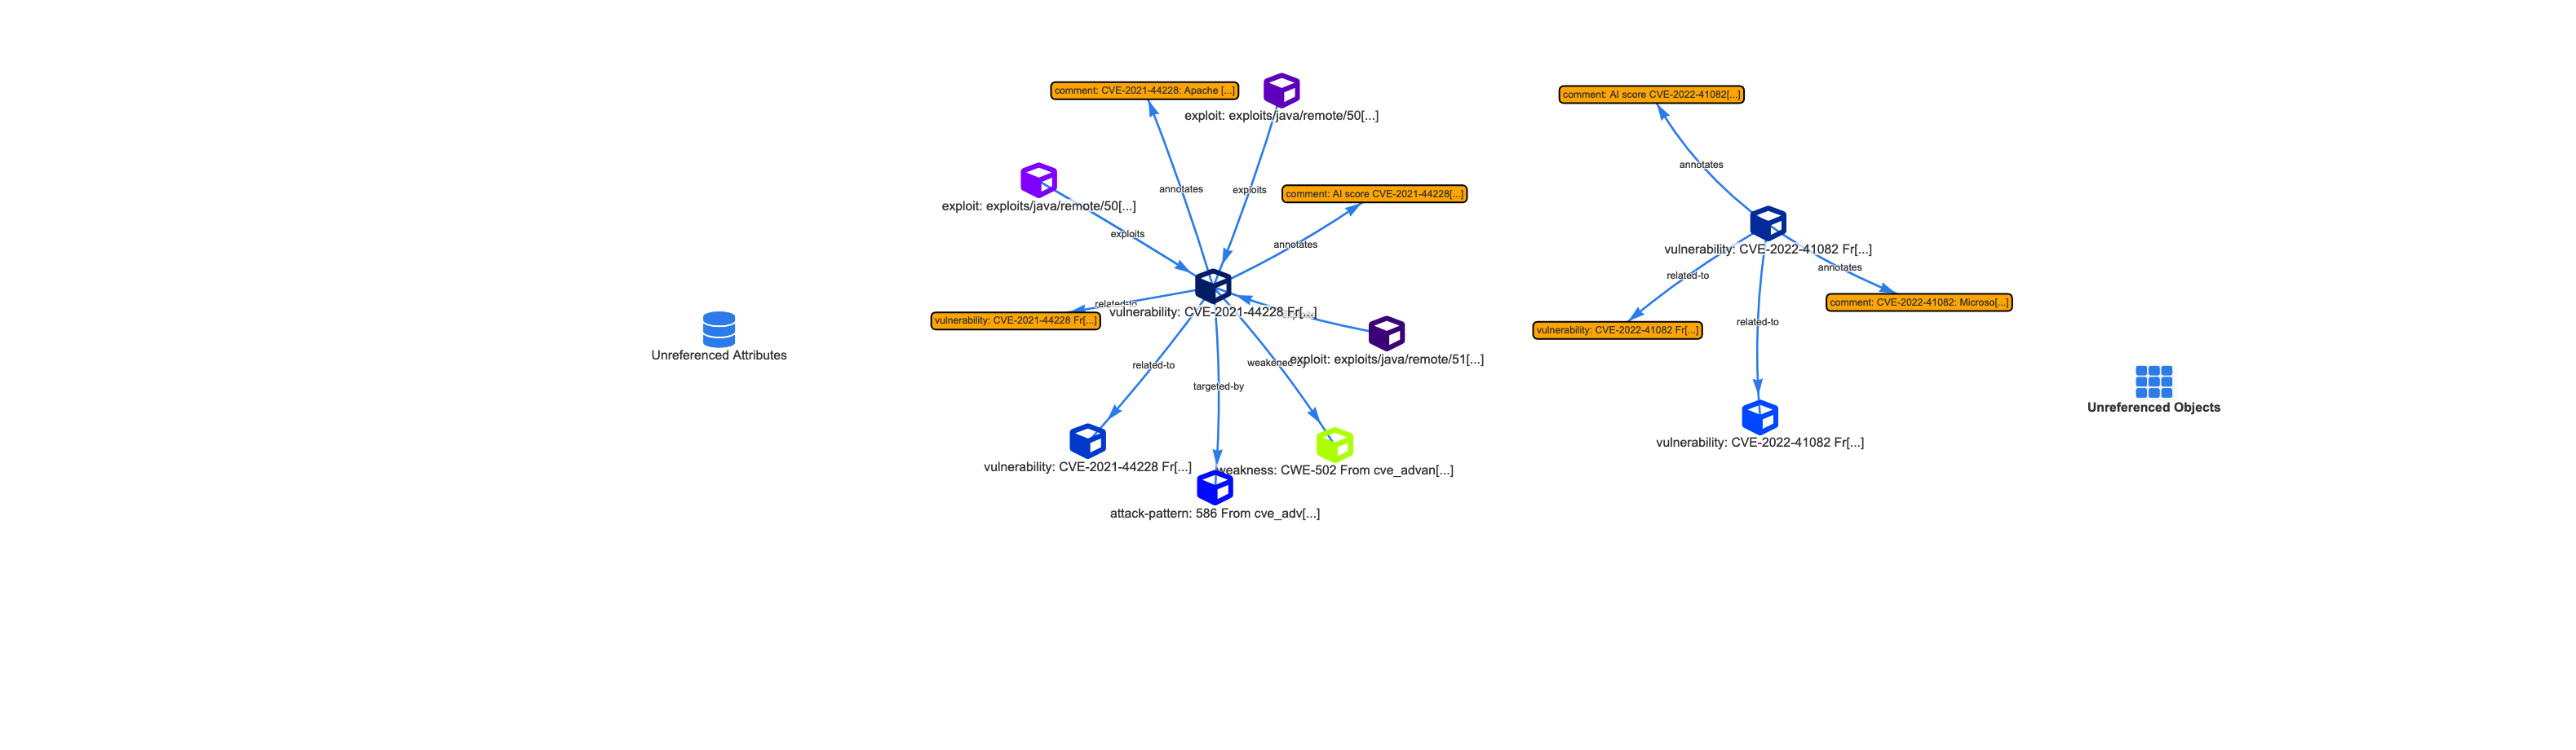

In [28]:
# Start with the first MISP Event graph
misp_eventgraph_id = 12

# We use the requests library and need to set the headers
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
event_graph = requests.get("{}/event_graph/viewPicture/{}/{}".format(misp_url, misp_event.id, misp_eventgraph_id), headers=misp_headers, verify=misp_verifycert)
if event_graph.status_code == 200:
    display(Image(event_graph.content, width=1200))
else:
    print("Event \033[91mgraph not found\033[90m. Continue with the playbook.\n\n")

## EN:6 End of the playbook 

In [27]:
print("\033[92m End of the playbook")


 End of the playbook


## External references

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)
- [TheHive](https://thehive-project.org/)
- [Mapping ATT&CK to CVE for impact](https://mitre-engenuity.org/cybersecurity/center-for-threat-informed-defense/our-work/mapping-attck-to-cve-for-impact/)

## Technical details 

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
pyfaup
chardet
PrettyTable
ipywidgets
```

You need to have **network access** to 
- your MISP server (HTTP or HTTPS)
- to your Mattermostand TheHive server
- to the website of CVE Advanced (https://cvepremium.circl.lu-, Vulners (https://vulners.com), ExploitDB (https://gitlab.com/exploit-database) and IBM XForceExchange (https://exchange.xforce.ibmcloud.com)

These **MISP modules** need to be enabled
- cve_advanced
- vulners
- xforceexchange

You need
- an **API key with MISP**
- - Under Global Actions, My Profile. Add an extra authentication key.
- - Add the API key (`misp_key`) and the MISP URL (`misp_url`) to `keys.py`
- - If you use a self-signed certificate set `misp_verifycert` to False
- an **API key with Vulners**
- - Add the API key (`vulners_apikey`) to `keys.py`.
- an **API key with XForce Exchange**
- - Add the API key (`xforce_apikey`) and API password (`xforce_apipassword`) to `keys.py`.
- an **incoming webhook in your Mattermost server**
- - Set this up under Integrations, Incoming Webhooks. Set as default channel your SOC/CSIRT team channel. For additional protection, lock the webhook so that the incoming webhook can post only to the selected channel.
- - Add the webhook to `mattermost_hook`. It is displayed under 'integrations/incoming_webhooks' and set a username under `mattermost_playbook_user`
- an **API key with your TheHive server**
- - Click on your username (upper right corner), Settings and then API key
- - Make sure that your user has 'manageAlert/create' privileges
- - Add the API key (`thehive_key`) to `keys.py` and add the URL to TheHive (`thehive_url`)

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```